In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

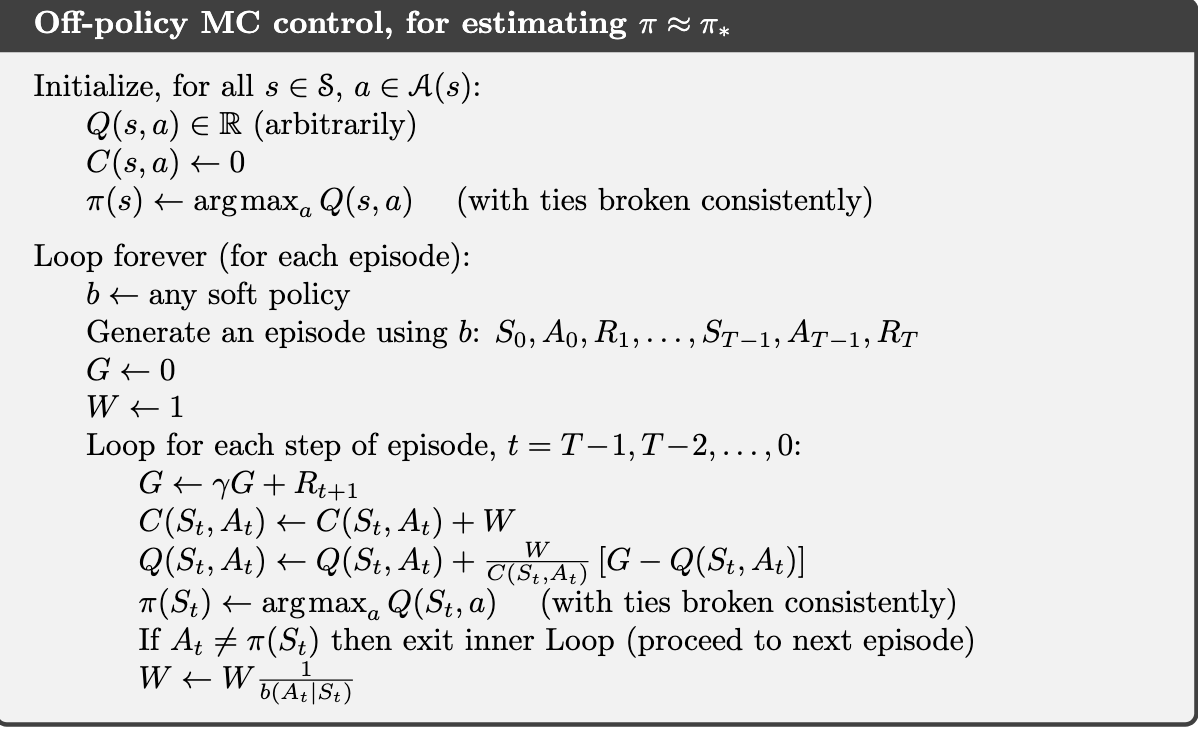

In [14]:
def off_policy_MC_control(env, b_eps=0.5, discount_factor=0.99, episodes=10000, max_t=100):
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    C = defaultdict(lambda: np.zeros(nA))
    target_policy = np.ones((nS, nA))/nA
    
    for i in range(episodes):
        if ((i+1)%100) == 0:
            print(i+1)
        uniform = np.ones((nS, nA), dtype=float) / nA
        b = (1-b_eps) * target_policy + b_eps * uniform #book says any eps-soft policy, but having it close to the eps-greedy leads to less variance
        episode = []
        state, _ = env.reset()
        steps = 0
        while(True):
            action = np.random.choice(nA, p=b[state])
            s_next, reward, term, trun, _ = env.step(action)
            steps+=1
            episode.append((state, action, reward))
            if term or trun:
                break
            if max_t is not None and steps >= max_t:
                break
            state = s_next
        
        G = 0.0
        W = 1.0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = discount_factor*G+r
            C[s][a] += W
            Q[s][a] += (W/C[s][a])*(G-Q[s][a])
            target_policy[s].fill(0.0)
            best = np.argmax(Q[s])
            target_policy[s][best]=1.0
            if a != best:
                break
            W = W/b[s][a]
    
    return target_policy, Q